In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import salty

from rdkit.Chem import Draw
from rdkit import Chem
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import AllChem as Chem
import warnings
warnings.filterwarnings('ignore')

T = [297, 316] # select state variable ranges according to manuscript
P = [99, 102] # we will set MD simulation to 101 kPa and 298 K
data_range = [[206, 2295]] #the cpt dataset has one outlier ~9,000 J/mol/K
exp_data = ["cpt"]
cpt_data = salty.aggregate_data(exp_data,T=T,P=P,data_ranges=data_range)
exp_data = ["density"]
dens_data = salty.aggregate_data(exp_data,T=T,P=P)
overlap_data = salty.aggregate_data(['cpt', 'density'], T, P)
union_data = salty.aggregate_data(['cpt', 'density'], T, P, merge='Union')
union_df = union_data.Data

df = pd.read_csv('../data/adaptive_learn_results.csv')
top_five_rdf_df = pd.read_hdf('../data/top_five_radial_distribution_functions.h5')
exp_rdf_df = pd.read_hdf('../data/experimental_radial_distribution_functions.h5')

name_dic = {
    'BRM': 'bromide',
    'THR': 'L-threoninate',
    'OSF': 'octyl sulfate',
    'TFS': 'trifluoromethanesulfonate',
    'TF2': 'bis[(trifluoromethyl)sulfonyl]imide',
    'BMI': '1-butyl-3-methylimidazolium',
    'EMI': '1-ethyl-3-methylimidazolium',
    'DAM': 'tributylmethylammonium',
    'EPY': '1-ethylpyridinium',
    'PPY': '1-ethyl-2-pentylpyridin-1-ium',
    'TTP': 'trihexyl(tetradecyl)phosphonium'
}

def draw(smiles):
    """
    draw smiles to notebook with RDKit
    """
    return Draw.MolToMPL(Chem.MolFromSmiles(smiles))

    
def sort_grab_smiles(sorted_df, number_of_items=5):
    """
    returns the top N (number_of_items) cation smiles 
    and anion names of the sorted df
    """
    sorted_df.reset_index(inplace=True, drop=True)
    ga_cations = []
    ga_anions = []
    for index, item in enumerate(sorted_df['Salt Smiles'][:number_of_items]):
        ga_cations.append(item.split(".")[0])
        ga_anions.append(sorted_df['Anion'][index])
    return ga_cations, ga_anions


def close_cations_and_scores(sorted_df, union_df, number_of_items=5):
    """
    returns the closest matching experimental cation with matching
    anion and its score
    """
    ga_cations, ga_anions = sort_grab_smiles(sorted_df, number_of_items)
    closest_cations = []
    closest_scores = []
    for index, item in enumerate(ga_anions):
        dff = union_df.loc[union_df['name-anion'] == item] # screen by anion
        unique_cations = dff['smiles-cation'].unique() # grab unique cations
        ms = [Chem.MolFromSmiles(ga_cations[index])] # set ms_0 to ga_cation
        for cation in unique_cations:
            ms.append(Chem.MolFromSmiles(cation)) # append unique cations
        fps = [FingerprintMols.FingerprintMol(x) for x in ms]
        scores = []
        for fp in fps[1:]:
            scores.append(DataStructs.FingerprintSimilarity(fps[0], fp))
        closest_cations.append(unique_cations[np.argmax(scores)])
        closest_scores.append(max(scores))
    return closest_cations, closest_scores


def display_match_results(ga_anions, name_dic, closest_cations, closest_scores):
    """
    displays match results for close_cations_and_scores function
    """
    for index, anion in enumerate(ga_anions):
        anion_abv = None
        cation_abv = None
        for item in name_dic:
            if name_dic[item] == anion:
                anion_abv = item
        for item in name_dic:
            if name_dic[item] == salty.check_name(closest_cations[index]):
                cation_abv = item
        print("{} {}\t score: {:.2f}\t ( {} {} )\t".format(cation_abv,
                                                    anion_abv,
                                                    closest_scores[index],
                                                    salty.check_name(closest_cations[index]),
                                                    anion))

# create high-cpt like species for comparison
def write_smiles_to_pdb(closest_cations, ga_anions, name_dic):
    """
    writes list of anions and cations to pdb using
    dictionary for conventional GROMACS pdb naming
    """
    name = None
    for i in closest_cations:
        ion = Chem.MolFromSmiles(i)
        ion = Chem.AddHs(ion)
        Chem.EmbedMolecule(ion, Chem.ETKDG())
        Chem.UFFOptimizeMolecule(ion)
        for item in name_dic:
            if name_dic[item] == salty.check_name(i):
                name = item
                print(name)
                Chem.MolToPDBFile(ion, '{}.pdb'.format(name))
    for i in ga_anions:
        ion = Chem.MolFromSmiles(salty.check_name(i))
        ion = Chem.AddHs(ion)
        Chem.EmbedMolecule(ion, Chem.ETKDG())
        Chem.UFFOptimizeMolecule(ion)
        for item in name_dic:
            if name_dic[item] == i:
                name = item
                print(name)
                Chem.MolToPDBFile(ion, '{}.pdb'.format(name))
%matplotlib inline

The following cell returns cations+anion smiles from the experimental datasets that closest match the cation+anion produced by the GA. Concretely, the experimental dataframe is filtered for systems matching the GA anion. The closest daylight fingerprinted tanimoto similarity cation to that of the GA cation is then returned from the filtered dataset, along with the original matching anion.

In [271]:
sorted_df = dff
ga_cations, ga_anions = sort_grab_smiles(sorted_df)
closest_cations, closest_scores = close_cations_and_scores(sorted_df, union_df)
display_match_results(ga_anions, name_dic, closest_cations, closest_scores)

BMI BRM	 score: 0.52	 ( 1-butyl-3-methylimidazolium bromide )	
EPY BRM	 score: 0.60	 ( 1-ethylpyridinium bromide )	
BMI TFS	 score: 0.51	 ( 1-butyl-3-methylimidazolium trifluoromethanesulfonate )	
TTP TF2	 score: 0.50	 ( trihexyl(tetradecyl)phosphonium bis[(trifluoromethyl)sulfonyl]imide )	
BMI BRM	 score: 0.52	 ( 1-butyl-3-methylimidazolium bromide )	


We can also compare structures directly using RDKit:

In [285]:
# change these two lines to whatever SMILES
cation_smiles_to_evaluate = dff.iloc[3]['Salt Smiles'].split(".")[0]
cation_to_compare_with = salty.check_name(name_dic['PPY'])

ms = [Chem.MolFromSmiles(cation_smiles_to_evaluate)]
ms.append(Chem.MolFromSmiles(cation_to_compare_with))

fps = [FingerprintMols.FingerprintMol(x) for x in ms]
scores = []
for fp in fps[1:]:
    scores.append(DataStructs.FingerprintSimilarity(fps[0], fp))
scores

[0.5085470085470085]

# RDFs of highest density and heat capacity GA ILs

In [338]:
dff = df.sort_values('calculated cpt', ascending=False)
dff.reset_index(inplace=True, drop=True)
cpt_keys = dff['Salt Smiles'][:5]
df1 = dff.iloc[:5]
dff = df.sort_values('calculated density', ascending=False)
dff.reset_index(inplace=True, drop=True)
density_keys = dff['Salt Smiles'][:5]
df2 = dff.iloc[:5]

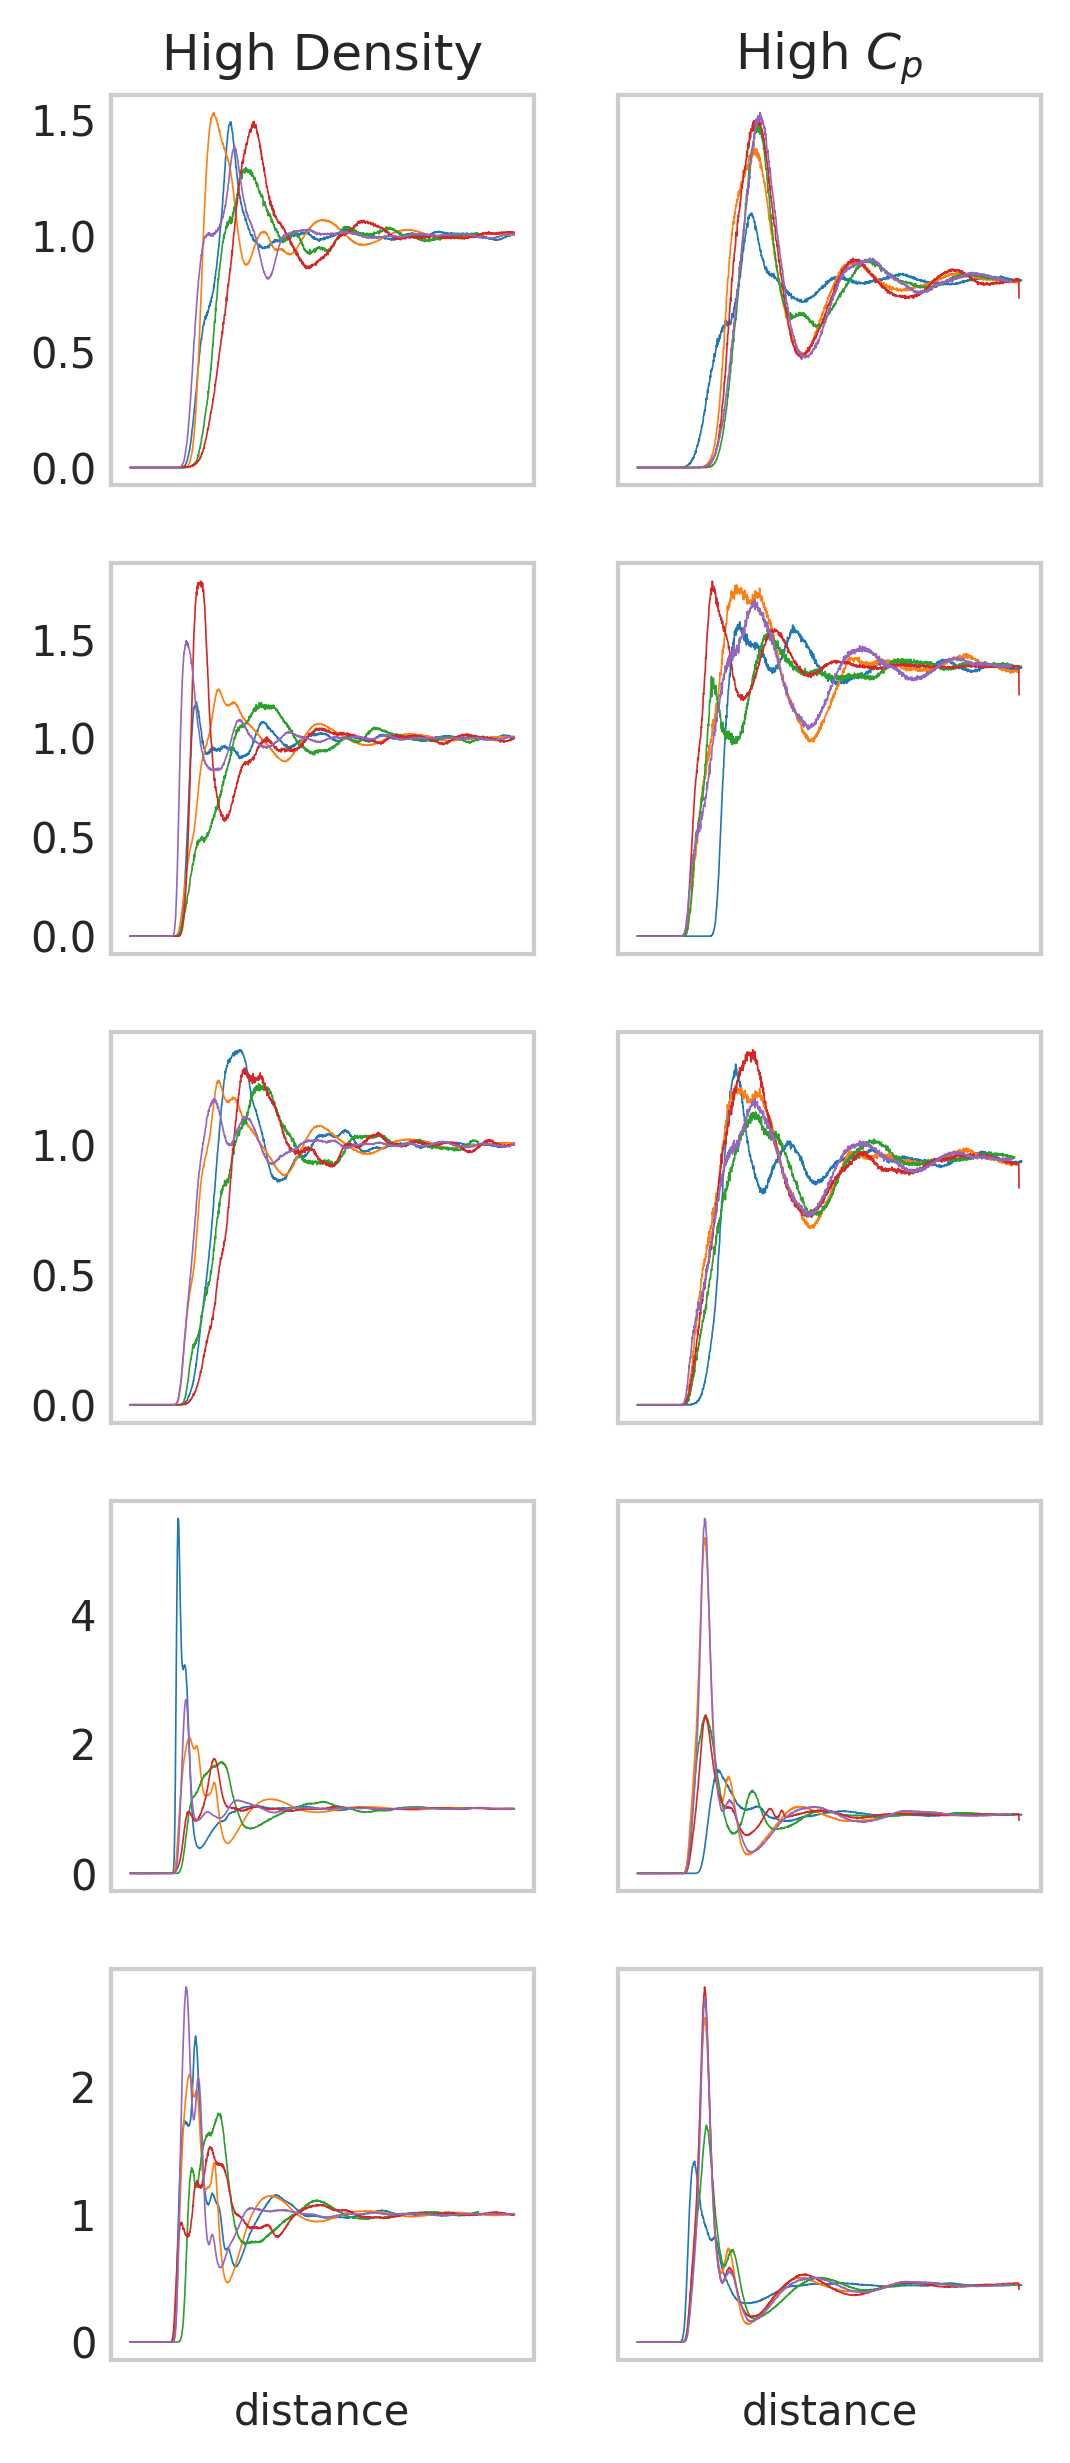

In [316]:
#full pictures........... 
# setup smi somewhere?
rdf_df = top_five_rdf_df
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(4,10), dpi=300)
    ax1=fig.add_subplot(521)
    ax2=fig.add_subplot(522)
    ax3=fig.add_subplot(523)
    ax4=fig.add_subplot(524)
    ax5=fig.add_subplot(525)
    ax6=fig.add_subplot(526)
    ax7=fig.add_subplot(527)
    ax8=fig.add_subplot(528)
    ax9=fig.add_subplot(529)
    ax10=fig.add_subplot(5,2,10)
    for i in density_keys:
        rdf_df[i]['inter-negative'].plot(ax=ax1, grid=False, sharex=True,
                                       alpha=1, linewidth=0.4, sharey=True,
                                        title='High Density')
        rdf_df[i]['inter-positive'].plot(ax=ax3, grid=False, sharex=True,
                                       alpha=1, linewidth=0.4)
        rdf_df[i]['inter-nitrogen'].plot(ax=ax5, grid=False, sharex=True,
                                       alpha=1, linewidth=0.4)
        rdf_df[i]['intra-charge'].plot(ax=ax7, grid=False, sharex=True,
                                       alpha=1, linewidth=0.4)
        rdf_df[i]['intra-nitrogen'].plot(ax=ax9, grid=False, sharex=True,
                                       alpha=1, linewidth=0.4)
    for i in cpt_keys:
        rdf_df[i]['inter-negative'].plot(ax=ax2, grid=False, sharex=True,
                                       alpha=1, linewidth=0.4,
                                        title='High $C_p$')
        rdf_df[i]['inter-positive'].plot(ax=ax4, grid=False, sharex=True,
                                       alpha=1, linewidth=0.4)
        rdf_df[i]['inter-nitrogen'].plot(ax=ax6, grid=False, sharex=True,
                                       alpha=1, linewidth=0.4)
        rdf_df[i]['intra-charge'].plot(ax=ax8, grid=False, sharex=True,
                                       alpha=1, linewidth=0.4)
        rdf_df[i]['intra-nitrogen'].plot(ax=ax10, grid=False, sharex=True,
                                       alpha=1, linewidth=0.4)

In [317]:
high_density_exp_keys = ['BMI.BRM', 'BMI.TFS', 'PPY.TF2']
high_cpt_exp_keys = ['BMI.OSF', 'DAM.THR']

In the top panels we're plotting the anion-anion charge center RDFs. We can see that the L-threonine (High Cp plot, orange line) is very similar to the L-threonine GA system and that the octyl sulfate (High Cp plot, blue line) is very similar to the ocyl sulfate GA systems.

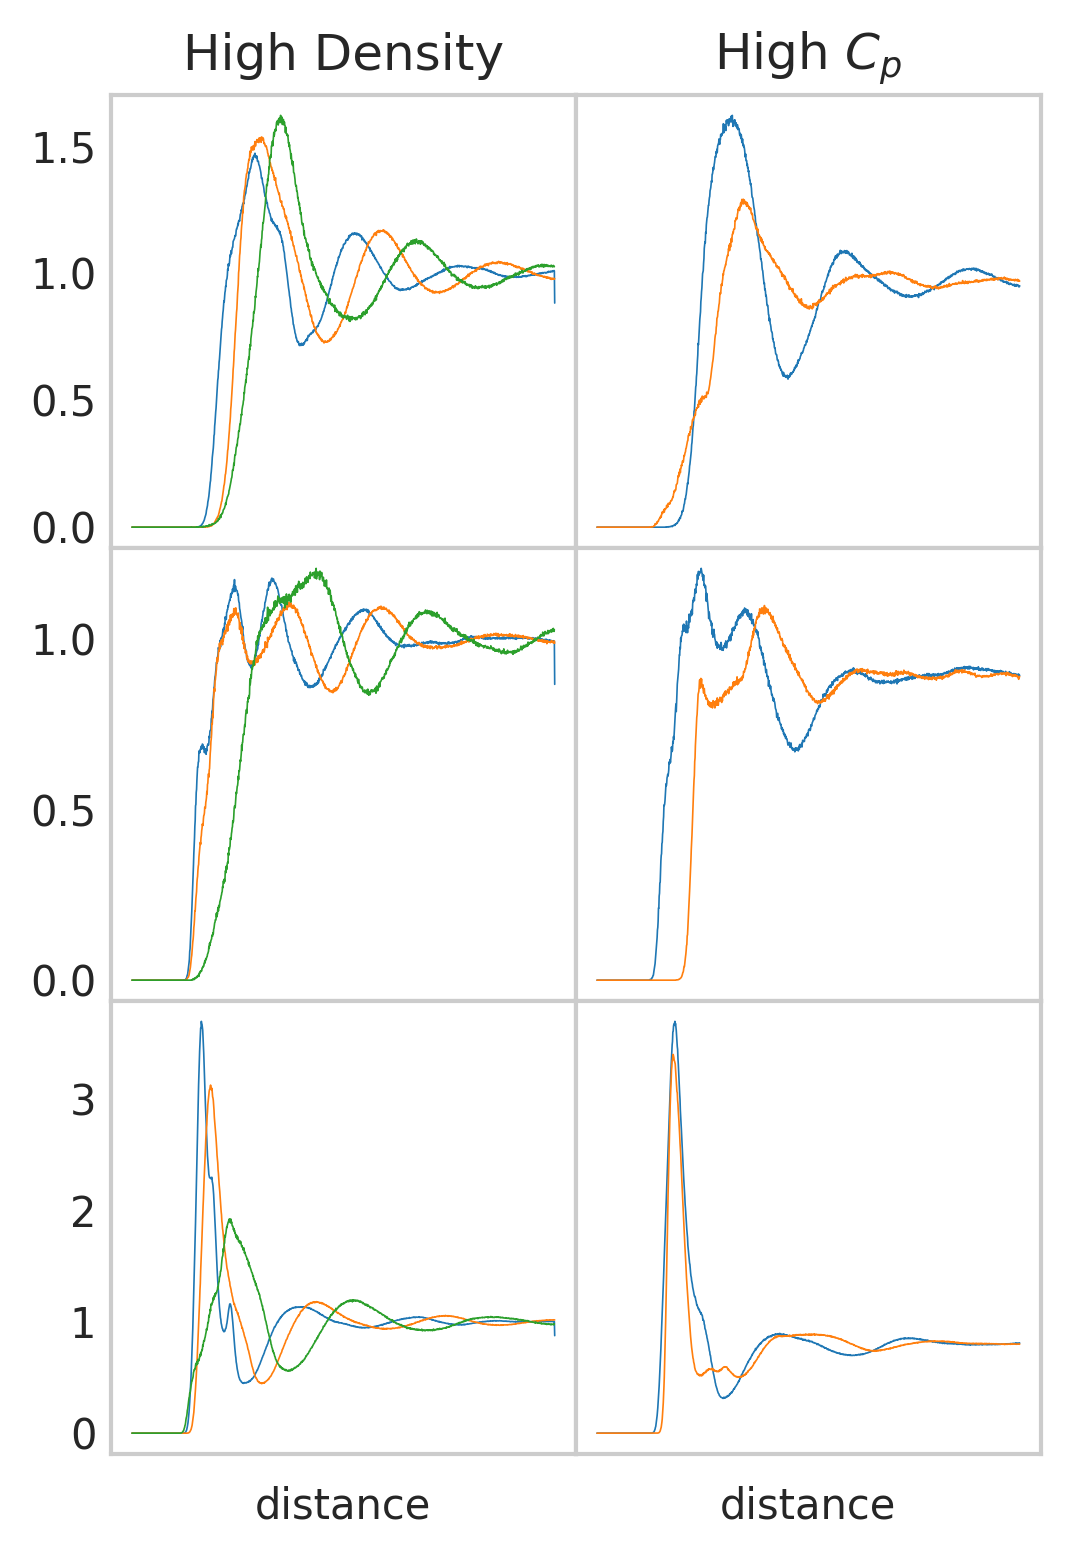

In [328]:
#full pictures........... 
# setup smi somewhere?
rdf_df = exp_rdf_df
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(4,6), dpi=300)
    ax1=fig.add_subplot(321)
    ax2=fig.add_subplot(322)
    ax3=fig.add_subplot(323)
    ax4=fig.add_subplot(324)
    ax5=fig.add_subplot(325)
    ax6=fig.add_subplot(326)
    for j in high_density_exp_keys:
        i = salty.check_name(name_dic[j.split(".")[0]])+'.'+\
            salty.check_name(name_dic[j.split(".")[1]])
        rdf_df[i]['inter-negative'].plot(ax=ax1, grid=False, sharex=True,
                                       alpha=1, linewidth=0.4, sharey=True,
                                        title='High Density')
        rdf_df[i]['inter-nitrogen'].plot(ax=ax3, grid=False, sharex=True,
                                       alpha=1, linewidth=0.4)
        rdf_df[i]['intra-charge'].plot(ax=ax5, grid=False, sharex=True,
                                       alpha=1, linewidth=0.4)
    for j in high_cpt_exp_keys:
        i = salty.check_name(name_dic[j.split(".")[0]])+'.'+\
            salty.check_name(name_dic[j.split(".")[1]])
        rdf_df[i]['inter-negative'].plot(ax=ax2, grid=False, sharex=True,
                                       alpha=1, linewidth=0.4,
                                        title='High $C_p$')
        rdf_df[i]['inter-nitrogen'].plot(ax=ax4, grid=False, sharex=True,
                                       alpha=1, linewidth=0.4)
        rdf_df[i]['intra-charge'].plot(ax=ax6, grid=False, sharex=True,
                                       alpha=1, linewidth=0.4)
    plt.subplots_adjust(left=None, 
                      bottom=None,
                      right=None,
                      top=None,
                      wspace=0,
                      hspace=0)

## Let's view the experimental and GA salts side-by-side

viewing the experimentally similar salt systems in the same plot as the GA systems show that the RDFs qualitatively agree with each other

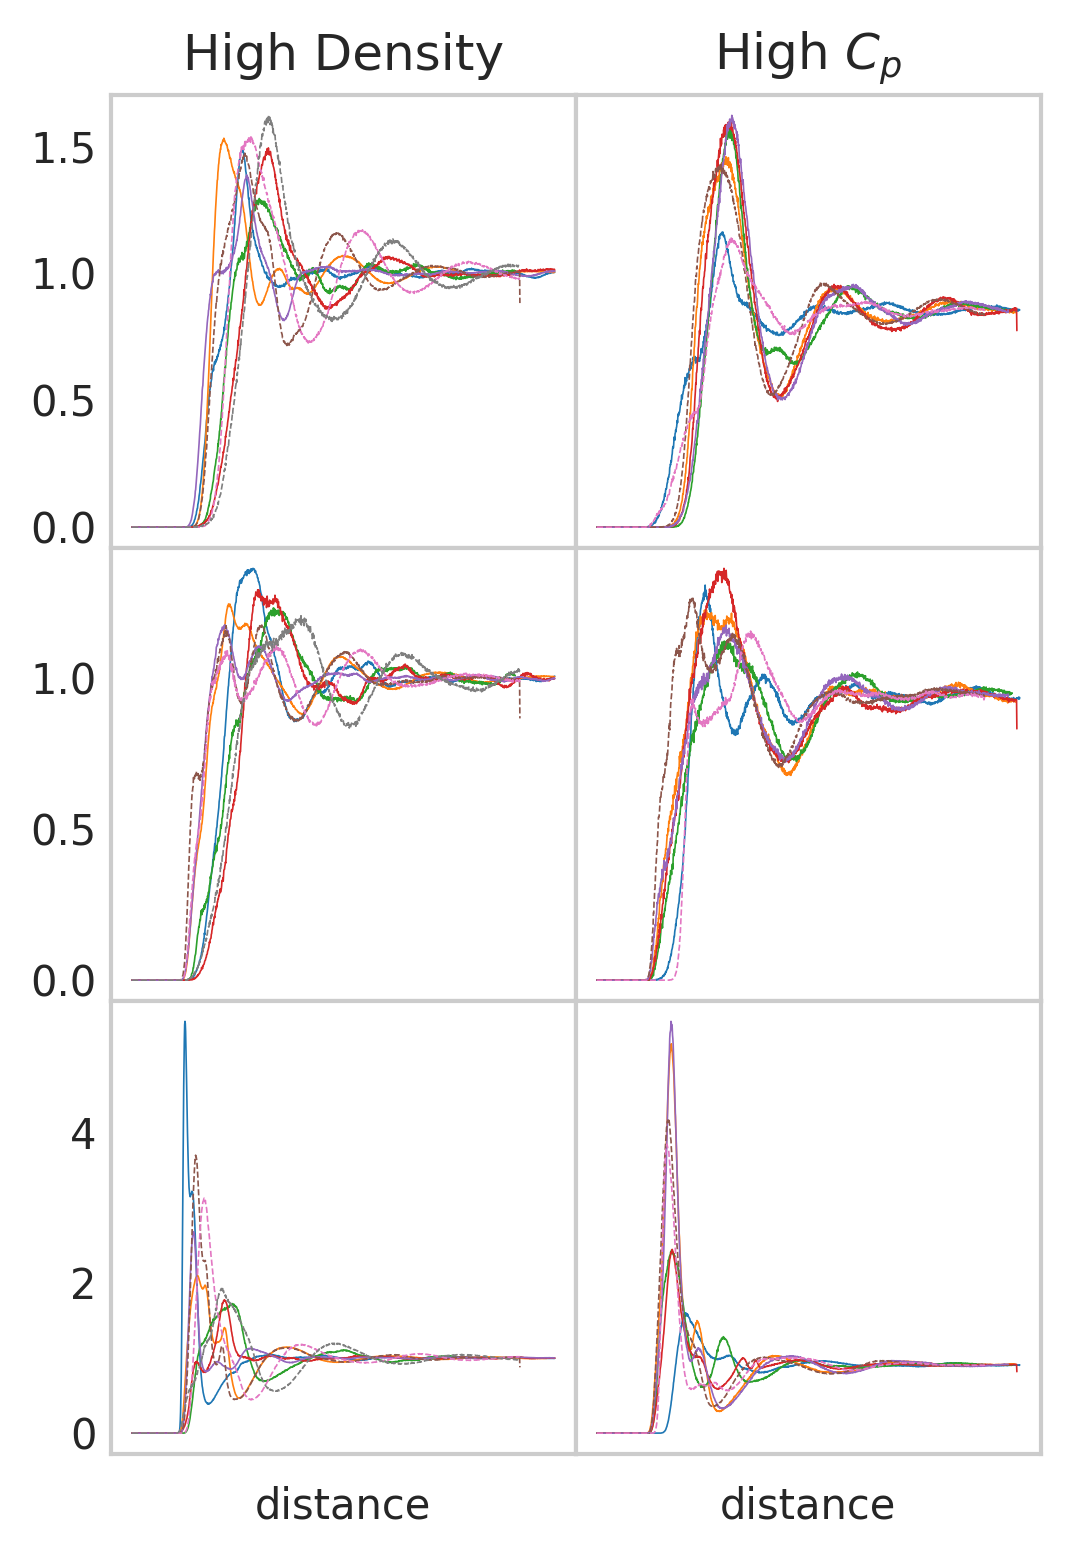

In [331]:
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(4,6), dpi=300)
    ax1=fig.add_subplot(321)
    ax2=fig.add_subplot(322)
    ax3=fig.add_subplot(323)
    ax4=fig.add_subplot(324)
    ax5=fig.add_subplot(325)
    ax6=fig.add_subplot(326)
    rdf_df = top_five_rdf_df
    for i in density_keys:
        rdf_df[i]['inter-negative'].plot(ax=ax1, grid=False, sharex=True,
                                       alpha=1, linewidth=0.4, sharey=True,
                                        title='High Density')
        rdf_df[i]['inter-nitrogen'].plot(ax=ax3, grid=False, sharex=True,
                                       alpha=1, linewidth=0.4)
        rdf_df[i]['intra-charge'].plot(ax=ax5, grid=False, sharex=True,
                                       alpha=1, linewidth=0.4)
    for i in cpt_keys:
        rdf_df[i]['inter-negative'].plot(ax=ax2, grid=False, sharex=True,
                                       alpha=1, linewidth=0.4,
                                        title='High $C_p$')
        rdf_df[i]['inter-nitrogen'].plot(ax=ax4, grid=False, sharex=True,
                                       alpha=1, linewidth=0.4)
        rdf_df[i]['intra-charge'].plot(ax=ax6, grid=False, sharex=True,
                                       alpha=1, linewidth=0.4)    
        
    rdf_df = exp_rdf_df
    for j in high_density_exp_keys:
        i = salty.check_name(name_dic[j.split(".")[0]])+'.'+\
            salty.check_name(name_dic[j.split(".")[1]])
        rdf_df[i]['inter-negative'].plot(ax=ax1, grid=False, sharex=True,
                                       alpha=1, linewidth=0.4, sharey=True,
                                        title='High Density',
                                        linestyle='--')
        rdf_df[i]['inter-nitrogen'].plot(ax=ax3, grid=False, sharex=True,
                                       alpha=1, linewidth=0.4,
                                        linestyle='--')
        rdf_df[i]['intra-charge'].plot(ax=ax5, grid=False, sharex=True,
                                       alpha=1, linewidth=0.4,
                                        linestyle='--')
    for j in high_cpt_exp_keys:
        i = salty.check_name(name_dic[j.split(".")[0]])+'.'+\
            salty.check_name(name_dic[j.split(".")[1]])
        rdf_df[i]['inter-negative'].plot(ax=ax2, grid=False, sharex=True,
                                       alpha=1, linewidth=0.4,
                                        title='High $C_p$',
                                        linestyle='--')
        rdf_df[i]['inter-nitrogen'].plot(ax=ax4, grid=False, sharex=True,
                                       alpha=1, linewidth=0.4,
                                        linestyle='--')
        rdf_df[i]['intra-charge'].plot(ax=ax6, grid=False, sharex=True,
                                       alpha=1, linewidth=0.4,
                                        linestyle='--')
    plt.subplots_adjust(left=None, 
                          bottom=None,
                          right=None,
                          top=None,
                          wspace=0,
                          hspace=0)